In [1]:
# Importing necessary modules
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets.fashionmnist_dataset import FashionMNISTDataset
from models.lenet5_model import LeNet5Model
from training.optimization_loop import OptimizationLoop
import torchvision
import torchvision.transforms as transforms
import sys
import matplotlib.pyplot as plt

In [2]:
# Read the test dataset into DataFrames
print("Loading test data from csv file...")
test_data_df = pd.read_csv('datasets/fashion-mnist/fashion-mnist_test.csv')
print("Test data shape:", test_data_df.shape)
sys.stdout.flush()

Loading test data from csv file...
Test data shape: (10000, 785)


In [3]:
# Separate images and labels
print("Separating images and labels...")
X_test_original = test_data_df.iloc[:, 1:].values # All columns except the first (label)
y_test_original = test_data_df.iloc[:, 0].values # First column (label)
print(f"X_test shape: {X_test_original.shape}, y_test shape: {y_test_original.shape}")
sys.stdout.flush()

Separating images and labels...
X_test shape: (10000, 784), y_test shape: (10000,)


In [4]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

In [5]:
# Load the test dataset
print("Creating FashionMNIST test dataset...")
test_dataset = FashionMNISTDataset(np.column_stack((y_test_original, X_test_original)), transform=transform)

Creating FashionMNIST test dataset...


In [6]:
# Create DataLoaders for the test dataset
print("Creating DataLoaders for test dataset...")
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Creating DataLoaders for test dataset...


In [7]:
# Grab a single mini-batch of images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print the shape of images and labels
print(images.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


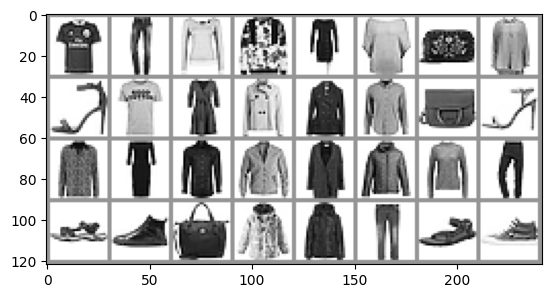

In [8]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Create a grid from the batch of images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# Check if a GPU is available and set the device accordingly
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(f"Using {device} device")

Using mps device


In [10]:
# Load the model
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, weights_only=True, map_location=device))
    model.to(device)
    return model

In [11]:
# Create a list of tuples containing model path and a friendly name
models_to_evaluate = [
    ('saved_models/fashionmnist_lenet5_relu_pytorch_ce_adam_1_model_weights.pth', 'Model 1'),
    ('saved_models/fashionmnist_lenet5_relu_pytorch_ce_adam_2_model_weights.pth', 'Model 2'),
    ('saved_models/fashionmnist_lenet5_relu_pytorch_ce_adam_3_model_weights.pth', 'Model 3'),
    ('saved_models/fashionmnist_lenet5_relu_pytorch_ce_adam_4_model_weights.pth', 'Model 4'),
    ('saved_models/fashionmnist_lenet5_relu_pytorch_ce_adam_5_model_weights.pth', 'Model 5')
]

In [12]:
# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Store the loss and accuracy for each model
test_results = []

# Test the models to evaluate their performance
for model_path, model_name in models_to_evaluate:
    print(f"Model: {model_name}")
    model = LeNet5Model()
    model = load_model(model, model_path, device)
    
    # Create an optimization loop for evaluation
    optimization_loop = OptimizationLoop(model, loss_fn, device=device)
    
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = optimization_loop.evaluate_loop(test_dataloader)

    # Store the results
    test_results.append({
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

Model: Model 1
Evaluation Error: 
 Accuracy: 90.1%, Avg loss: 0.271028 

Model: Model 2
Evaluation Error: 
 Accuracy: 89.6%, Avg loss: 0.277871 

Model: Model 3
Evaluation Error: 
 Accuracy: 90.3%, Avg loss: 0.271507 

Model: Model 4
Evaluation Error: 
 Accuracy: 89.6%, Avg loss: 0.293333 

Model: Model 5
Evaluation Error: 
 Accuracy: 89.4%, Avg loss: 0.294131 



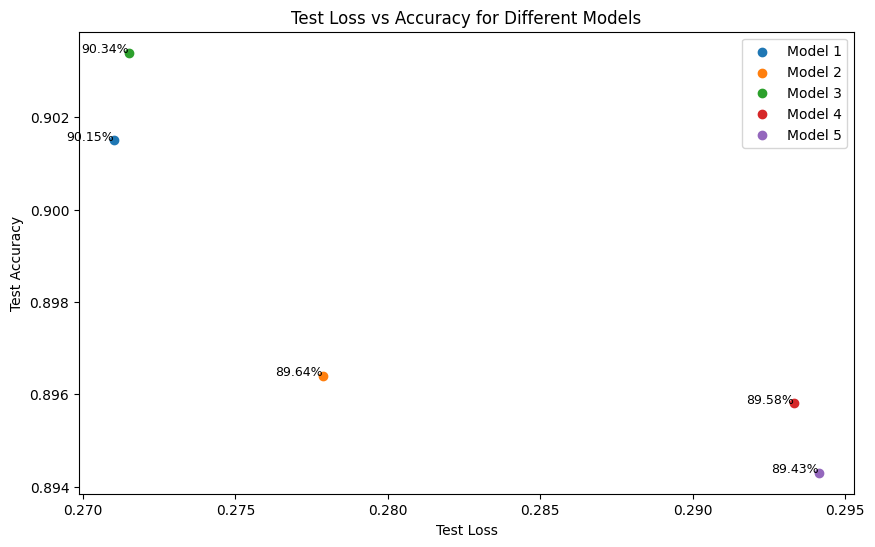

In [13]:
# Plot the results in a scatter plot
plt.figure(figsize=(10, 6))
for result in test_results:
    # Plot each model's test loss vs accuracy and show the value alongside the point
    plt.scatter(result['test_loss'], result['test_accuracy'], label=result['model_name'])
    plt.text(result['test_loss'], result['test_accuracy'], f"{result['test_accuracy']*100:.2f}%", fontsize=9, ha='right')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.title('Test Loss vs Accuracy for Different Models')
plt.legend()
plt.show()